# Analysis of the dependence of signatures of selection on lineage size and mutational diversity (related to Figure S4)

In [231]:
from __future__ import division
import sys
import os
import time
import copy
import pickle

import numpy as np
import pandas as pd
import scipy

%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib as mpl
from matplotlib import gridspec
import seaborn as sns

import bct

output_dir = "outs"
output_suffix = ""
output_formats = [".pdf", ".png"]

def save_figure(fig, name, output_dir, output_suffix, output_formats, savefig_args):
    if savefig:
        for output_format in output_formats:
            fig.savefig(output_dir + "/" + name + output_suffix + output_format, **savefig_args)
    return None

savefig = True
savefig_args = {"dpi": 300, "bbox_inches": "tight", "pad_inches": 0.2}
mpl.rc('savefig', dpi=300)

mpl.rcParams['figure.dpi']= 300

sns.set_style("ticks")
sns.set_context("talk")

myColors = ["#E69F00", "#56B4E9", "#D55E00", "#009E73", "#7570b3", "#e31a1c", "#fb9a99", "#cab2d6"]

# Load data

In [2]:
# Lineage dynamics data
df_expanded = pd.read_csv("data/df_expanded.filtered.csv", index_col=0)
df_persistent = pd.read_csv("data/df_persistent.filtered.csv", index_col=0)

print "Lineages"
print "Expanded", df_expanded.shape[0]
print "Persistent", df_persistent.shape[0]

Lineages
Expanded 87
Persistent 192


In [3]:
# Load frequencies of mutations for all lineages
freqs = pickle.load(open("data/SFS_Bulk_freqs.pickle"))

# Load number of leaves in each lineage
lineage_sizes = pickle.load(open("data/SFS_Bulk_lineage_sizes.pickle"))

In [4]:
# Metrics of selection
df_metrics = pd.read_csv("data/df_metrics.slim.csv", index_col=0)
df_metrics.head()

,label_dynamics,num_seq,H,H_pvalue_kingman,H_pvalue_neutralExpanding,num_seq_bin
lineage_uid,,,,,,
70201010000000001,Vaccine-responsive,9166,-14.499747,0.000571,2.096066e-10,10000
20201010000000001,Vaccine-responsive,15632,18.579027,1.000000,1.000000e+00,10000
20201010000000267,Vaccine-responsive,5722,17.182397,1.000000,1.000000e+00,5000
60201010000000781,Vaccine-responsive,6943,3.886945,0.999978,4.189248e-03,5000
20201010000000362,Vaccine-responsive,6586,23.854739,1.000000,1.000000e+00,5000


# Examine whether size has any systematic effect on detection of selection

In [5]:
# Sort lineages by size
df_metrics.sort_values(by="num_seq", ascending=True, inplace=True)

df_metrics_expanded = df_metrics.loc[df_metrics["label_dynamics"] == "Vaccine-responsive"]
df_metrics_persistent = df_metrics.loc[df_metrics["label_dynamics"] == "Persistent"]

df_metrics.head()

,label_dynamics,num_seq,H,H_pvalue_kingman,H_pvalue_neutralExpanding,num_seq_bin
lineage_uid,,,,,,
60201010000012295,Persistent,100,19.213737,1.000000,1.000000,100
60201010000089359,Persistent,101,10.015446,1.000000,0.999978,100
20201010000088542,Persistent,101,10.531683,1.000000,0.999987,100
70201010000033334,Vaccine-responsive,103,-9.300781,0.002835,0.000005,100
60201010000098592,Persistent,103,10.491338,1.000000,0.999986,100


In [220]:
df_metrics_epr = pd.read_csv("data/df_metrics_epr.csv", index_col=0)

In [221]:
df_metrics_epr.head()

,label_dynamics,num_seq,H,H_pvalue_kingman,H_pvalue_neutralExpanding
lineage_uid,,,,,
70201010000000001,Vaccine-responsive,9166,-14.499747,0.000571,2.096066e-10
20201010000000001,Vaccine-responsive,15632,18.579027,1.000000,1.000000e+00
20201010000000267,Vaccine-responsive,5722,17.182397,1.000000,1.000000e+00
60201010000000781,Vaccine-responsive,6943,3.886945,0.999978,4.189248e-03
20201010000000362,Vaccine-responsive,6586,23.854739,1.000000,1.000000e+00


Correlation between sequences and P value
(-0.07946252949607563, 0.0922532798891597)


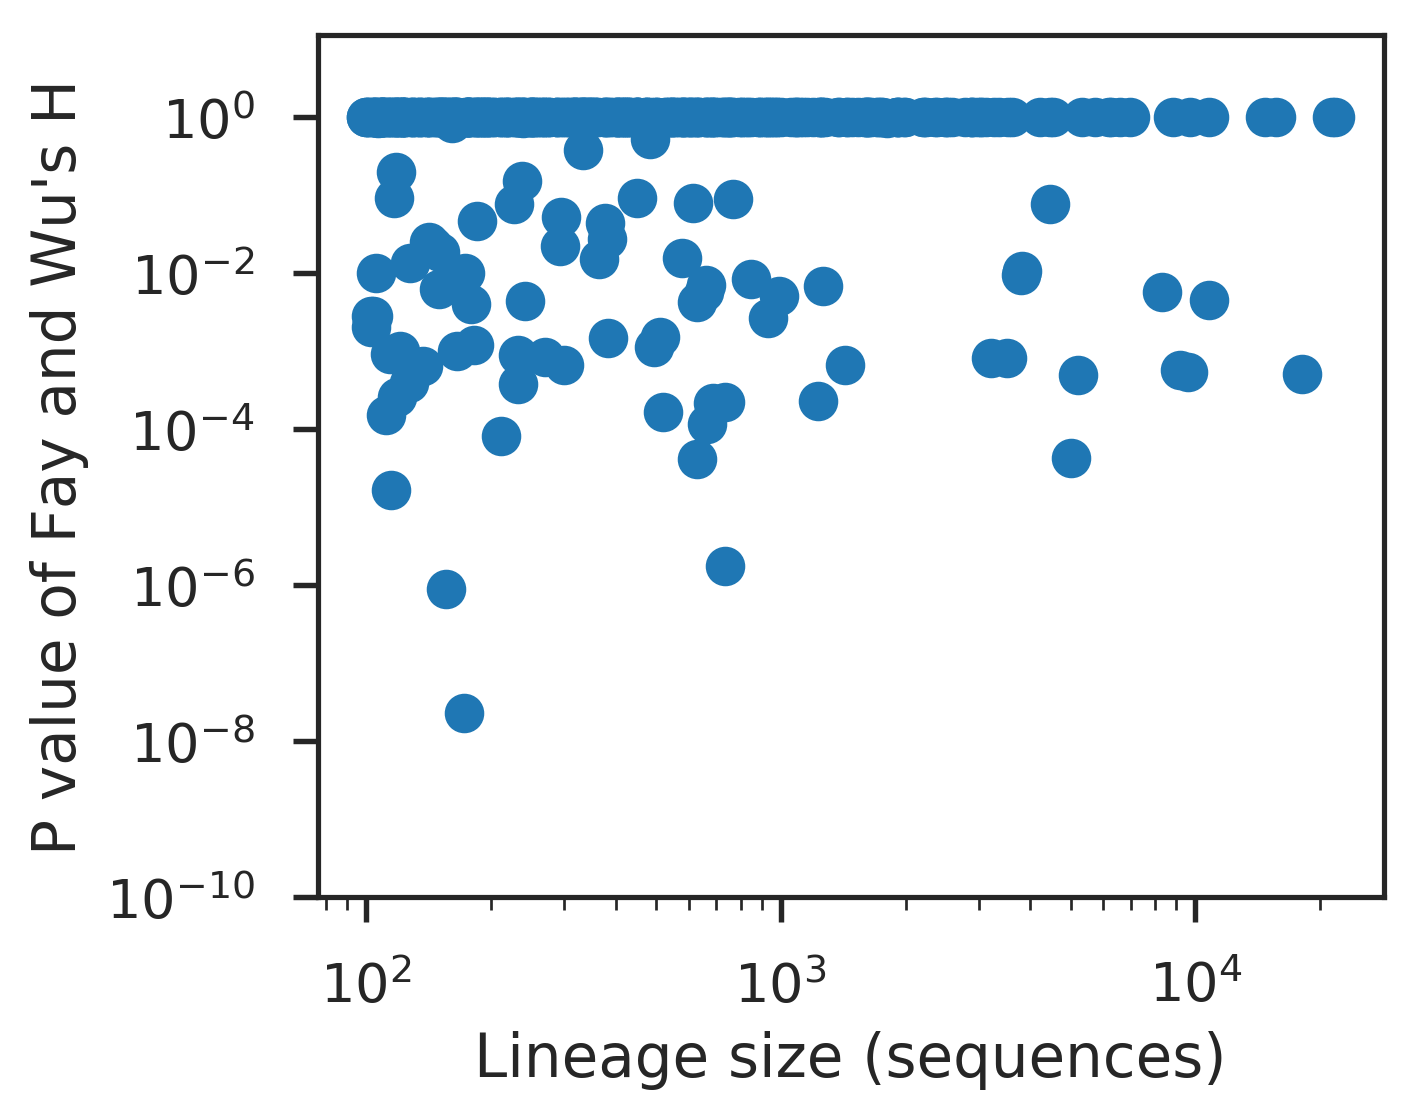

In [227]:
x = df_metrics_epr["num_seq"]
y = df_metrics_epr["H_pvalue_kingman"]

fig, ax = plt.subplots(1, 1, figsize=(5,4))
ax.scatter(x, y)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylim(bottom=1e-10)
ax.set_xlabel("Lineage size (sequences)")
ax.set_ylabel("P value of Fay and Wu's H")
plt.tight_layout()

print "Correlation between sequences and P value"
print scipy.stats.pearsonr(x, y)

# Analysis of selection versus total branch length

## Calculate total branch length of each lineage

In [88]:
from Bio import Phylo
import glob

# Find all trees

infiles_dir = "/scratch/Bcell_selection/data/trees"

filenames_trees = glob.glob(infiles_dir + "/*/fasttree.rep.named.nwk")
lineage_uids = [x.split("/")[5] for x in filenames_trees]

# Calculate total branch length for each tree

total_branch_lengths = {}

for infile in filenames_trees:
    T = Phylo.read(infile, "newick")
    lineage_uid = infile.split("/")[5]
    L = T.total_branch_length()
    total_branch_lengths[lineage_uid] = L
    
# Add information to dataframe

col_total_branch_lengths = []
for x in df_metrics.index:
    x = str(x)
    if x in total_branch_lengths:
        col_total_branch_lengths.append(total_branch_lengths[x])
    else:
        col_total_branch_lengths.append(np.nan)
        
df_metrics["total_branch_length"] = col_total_branch_lengths

df_metrics.head()

,label_dynamics,num_seq,H,H_pvalue_kingman,H_pvalue_neutralExpanding,num_seq_bin,total_branch_length
lineage_uid,,,,,,,
60201010000012295,Persistent,100,19.213737,1.000000,1.000000,100,1.56352
60201010000089359,Persistent,101,10.015446,1.000000,0.999978,100,1.24641
20201010000088542,Persistent,101,10.531683,1.000000,0.999987,100,4.13713
70201010000033334,Vaccine-responsive,103,-9.300781,0.002835,0.000005,100,0.43483
60201010000098592,Persistent,103,10.491338,1.000000,0.999986,100,1.98045


In [89]:
df_metrics_expanded = df_metrics.loc[df_metrics["label_dynamics"] == "Vaccine-responsive"]
df_metrics_persistent = df_metrics.loc[df_metrics["label_dynamics"] == "Persistent"]

Correlation between sequences and total branch length, VR
(0.7963411753018885, 4.929558184088097e-20)
Correlation between sequences and total branch length, P
(0.2883289320262001, 5.000988029844037e-05)
Correlation between sequences and total branch length, all lineages
(0.5137795622908985, 3.959949756489959e-20)


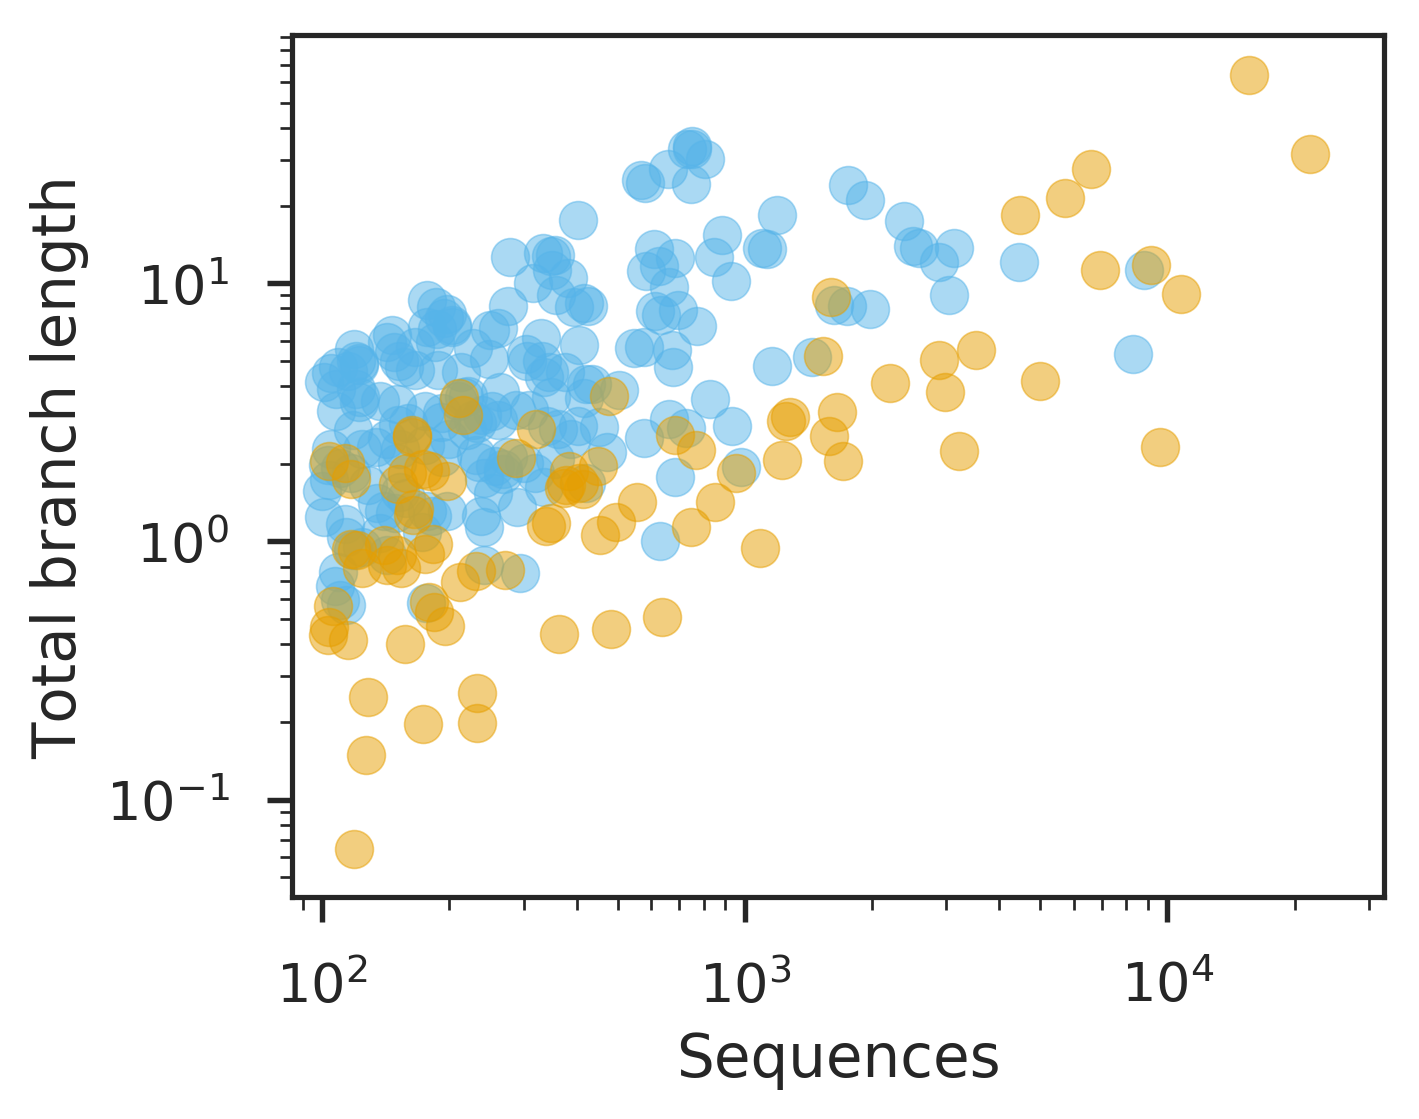

In [141]:
# Correlation of total branch length and number of sequences

fig, ax = plt.subplots(1, 1, figsize=(5,4))

y = df_metrics_expanded["total_branch_length"].dropna()
x = df_metrics_expanded.loc[y.index]["num_seq"]
ax.scatter(x, y, c=myColors[0], alpha=0.5, zorder=10)

x_clean = x.dropna()
y_clean = y.loc[x_clean.index]
print "Correlation between sequences and total branch length, VR"
print scipy.stats.pearsonr(x_clean, y_clean)

y = df_metrics_persistent["total_branch_length"].dropna()
x = df_metrics_persistent.loc[y.index]["num_seq"]
ax.scatter(x, y, c=myColors[1], alpha=0.5)

x_clean = x.dropna()
y_clean = y.loc[x_clean.index]
print "Correlation between sequences and total branch length, P"
print scipy.stats.pearsonr(x_clean, y_clean)

ax.set_xscale("log")
ax.set_xlim(left=85)
ax.set_yscale("log")

ax.set_xlabel("Sequences")
ax.set_ylabel("Total branch length")
plt.tight_layout()

y = df_metrics["total_branch_length"].dropna()
x = df_metrics.loc[y.index]["num_seq"]
x_clean = x.dropna()
y_clean = y.loc[x_clean.index]
print "Correlation between sequences and total branch length, all lineages"
print scipy.stats.pearsonr(x_clean, y_clean)

